In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 18

In [3]:
%load_ext jupyter_spaces

### Summary

We benchmark the previously discussed lattice_array code against a different approach by A.Ipp found [here](https://colab.research.google.com/drive/1HvpnLtOOQ9ETDCSUf_wJvGVUFzbgvVO4?usp=sharing#scrollTo=GmCh0OPmNNNC).

Although the code by A.Ipp uses Numpy functions exclusively and looks more simple, it is still slower than the more complicated (and yet still unoptimized) lattice_array code.  
Other problems with the Numpy versions are:
- It only yields the final Numpy arrays used for plotting.
- The whole mesh is generated at once, so no simple way to convert it to iterators and only have one time slice in memory.
- It makes heavy use of resizing Numpy arrays (not only views) and thus works on many different arrays. For lager meshes this will come at an increased cost.

### Previous Code

In [4]:
def generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas):
    """Generate the lattice array defining the layout.
    
    Args:
        cells_areas:
            Nested 2D Python list with width of each area
            in units of the stepping for that area.
        width_areas:
            Nested 2D Python list with spatial stepping
            for each area.
        dt_areas:
            Nested 2D Python list with temporal stepping
            for each erea.
    
    All arguments must share the same size for the outermost
    list and all sublists with the same position in their list
    must share the same size as well.
    
    Returns:
        Numpy array with Python lists as elements that fully
        characterizes the lattice. First dim is the number
        of time steps inherited from the arguments.
    """
    # find number of time steps Nt
    # take max so loop in next line raises error for wrong arguments
    time_steps = max(len(cells_areas), len(width_areas), len(dt_areas))

    l = np.empty(time_steps, dtype=object)
    for i in range(time_steps):
        l[i] = tuple((t, w, c) for t, w, c in zip(dt_areas[i], width_areas[i], cells_areas[i]))
        
    return l

In [5]:
def generate_plot_lattice_1_1D(lattice_array):
    """Generate a Numpy array with the given cell layout.

    Args:
        lattice_array:
            Return value of `generate_lattice_array`. Numpy
            array with length equal the time steps and each
            element being a Python tuple of variable length
            containing Python tuples of length 3.

    Returns:
        Boolean Numpy array representation of the lattice
        with `shape = (2*Nt+1, 2*Ns+1)`. Nt: number of time
        slices, Ns: number of spatial cells, both given in
        units of the overall finest resolution.  
        The return array is meant to be used with the custom
        plotting routines based on matplotlib `imshow`.
    """
    # time steps in finest mesh units
    time_steps = len(lattice_array)
    
    # find spatial resolution in finest mesh units
    # has to be the same for all time slices => take 0
    fine_mesh = 0
    for areas in lattice_array[0]:
        # times two because of border pixels
        fine_mesh += areas[1] * areas[-1]*2

    # double size, borders take 1px
    # +1 for outermost boundary
    full_lattice = np.zeros((time_steps*2+1, fine_mesh+1), dtype=np.bool_)
    # needs different type for figuring out time step width of cells
    time_lattice = np.zeros((time_steps*2+1, fine_mesh+1), dtype=np.uint64)

    # set outermost boundary
    full_lattice[-1] = True
    full_lattice[:,-1] = True
    
    # fill lattice_array
    for i in range(time_steps):
        start = 0
        for areas in lattice_array[i]:
            # times two, because of border pixels
            stop = start+areas[-1]*areas[1]*2
            # set correct spatial step with proper stepping through mesh
            full_lattice[2*i, start : stop : areas[1]*2] = areas[1]
            full_lattice[2*i +1, start : stop : areas[1]*2] = areas[1]
            # set time step for all elements
            time_lattice[2*i, start : stop] = areas[0]
            time_lattice[2*i +1, start : stop] = areas[0]
            # set new start
            start = stop
        
        if start != fine_mesh:
            raise Exception(
                "Invalid lattice_array!\n"
                "The number of spatial cells varies between time steps!\n"
                f"{i=}, {lattice_array[i]=}, {fine_mesh=}, {start=}"
            )

    # set subsequent cells with dt>1 to zero
    # just like for coarser spatial stepping
    for i in range(0, time_steps*2, 2):
        # set smallest time slice borders
        time_lattice[i+1] = 0
        # if there exist coarser time steps
        for t in range(1, np.max(time_lattice[i])):
            time_lattice[i + 2*t][time_lattice[i] > t] = 0
    
    # only keep 0 where both full and time lattice are 0
    np.logical_or(full_lattice, time_lattice, out=full_lattice)
    return full_lattice

In [6]:
def plot_mesh_1_1D(lattice):
    """Plot the mesh corresponding to `lattice`.

    Args:
        lattice:
            Boolean Numpy array with `True` where to draw borders.
            Takes return value of `generate_plot_lattice_1_1D`.
            Shape needs to be (2*Nt+1, 2*Ns+1). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.

    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    ax.set_frame_on(False)
    
    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")
    
    ax.imshow(lattice, origin="lower")
    
    return fig, ax

In [7]:
# FIXME: does not plot field values correctly!!!
def plot_filled_mesh_1_1D(field, lattice):
    """Color a `lattice` with values from `field`.

    Args:
        field: Numpy array with field values to plot. Shape
            needs to be (Nt, Ns). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.
        lattice:
            Boolean Numpy array with `True` where to draw borders.
            Takes return value of `generate_plot_lattice_1_1D`.
            Shape needs to be (2*Nt+1, 2*Ns+1). Nt: number of time
            slices, Ns: number of spatial cells, both given in
            units of the overall finest resolution.

    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    ax.set_frame_on(False)
    
    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")
    
    # convert lattice array to masked array with only values
    # for borders and transparent cells
    grid = np.ma.masked_equal(lattice, False, copy=False)
    
    ax.imshow(field, origin="lower", extent=(-0.5, grid.shape[1]-1.5, -0.5, grid.shape[0]-1.5))
    ax.imshow(grid, origin="lower", interpolation="none", cmap="gray")
    
    return fig, ax

In [8]:
def borders_diag_lowL_uppR_segment(coarse_steps, spatial_width):
    """Generate lattice_array segment.
    
    The segment will have `coarse_steps` number of differently
    resolved regions (counting the finest). The borders will be
    diagonally from the lower left to the upper right.
    
    Args:
        coarse_steps: Integer number of different regions.
        spatial_width:
            Even number that sets the width of all coarser than
            finest resolved regions in the spatial direction.
            Minimal value must be $2^{coarse\_steps}$.
            
    Returns:
        1+1D lattice_array as output from `generate_lattice_array_1_1D`
        with len = $2^{coarse\_steps}$ and each element being a tuple
        of 3 tuples of (dt,dx,number). Here number is related to
        `spatial_width`.
    """
    # determine temporal steps to consider
    time_steps = int(2**coarse_steps)
    # prepare return variables
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)

    # spatial width per area
    start = tuple(spatial_width // 2**coa for coa in range(coarse_steps-1, 0, -1))
    # TBD:
    # second possibility, more memory usage, but less if and calc
    start1 = tuple(s+1 for s in start)
    sstart = (start, start1)
    # width in units of finest mesh for each area
    # include 1 for finest mesh, exclude 2**coarse_steps for coarsest mesh
    width_area = tuple(2**coa for coa in range(coarse_steps-1, -1, -1))
    
    coa1 = coarse_steps-1

    # generate the lattice_array components
    for i in range(2**coa1):
        # the binary encoding of alternating rows (gives straight edge)
#         binIdx = f"{i:{coa1}b}".replace(' ','0')
        # number of cells per area
#         cells_area = [ start[k] if binIdx[k]=='0' else start[k]+1
#                        for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        # TBD:
        # second possibility
        binIdx = tuple(map(int, f"{i:{coa1}b}".replace(' ','0')))
        cells_area = [ sstart[binIdx[k]][k] for k in range(coa1) ] + [2**coarse_steps -2*i -1]

        cells_areas[2*i] = tuple(cells_area)
        width_areas[2*i] = width_area[:]
        cells_areas[2*i + 1] = tuple(cells_area)
        width_areas[2*i + 1] = width_area[:]

    # allow only squares
    dt_areas = width_areas
    
    return generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)

In [9]:
def spatial_lattice_array_mirror(l):
    """Mirror the given lattice array in spatial direction.
    
    This returns a new Numpy array.
    """
    out = np.empty(len(l), dtype=object)
    for t,ll in enumerate(l):
        out[t] = tuple(reversed(ll))
    return out

In [10]:
def temporal_lattice_array_mirror(l):
    """Mirror the given lattice array in temporal direction.
    
    This does not modify `l` in place, but returns a view of `l`.
    """
    return np.flipud(l)

In [11]:
def spatial_lattice_array_extend(left, right):
    """Append the lattice array `right` to the spatial right of `left`.
    
    Args:
        left: `lattice_array` on the spatial left.
        right: `lattice_array` on the spatial right.
    
    Both arguments must have the same len.
    
    Returns:
        New `lattice_array` with len matching the inputs. If
        the touching regions of `left` and `right` have equal
        resolution, they get merged.
    """
    # take max, so that loop below throws error for mismatched shape
    out = np.empty(max(len(left), len(right)), dtype=object)
    for t in range(len(out)):
        # check for merge possibility
        # both, temporal and spatial must be equal
        if left[t][-1][0] == right[t][0][0] and left[t][-1][1] == right[t][0][1]:
            middle = ((left[t][-1][0], left[t][-1][1], left[t][-1][-1]+right[t][0][-1]),)
            out[t] = tuple(left[t][:-1] + middle + right[t][1:])
        else:
            out[t] = tuple(left[t] + right[t])
    
    return out

In [12]:
def propagate_pulse(l, steps, buffer=1):
    """Propagate a single pulse from lower left to upper right.
    
    Args:
        l: Pulse segment to propagate.
        steps: Number of times to repeat `l` in temporal direction.
        buffer:
            Default 1. Number of coarsest cells to insert in order
            to prevent the pulse form touching the box boundaries.
    
    Returns:
        New `lattice_array` with `steps * len(l)` as len and
        all time slices filling the same total spatial width.
    """
    # get width of l in units of finest mesh, times 2 for next region to add
    # get them from boundary area, as pulse segment is symmetric
    l_coarsest_t = l[0][0][0] *2
    l_coarsest_x = l[0][0][1] *2
    out_t = steps * len(l)
    out = np.empty(out_t, dtype=object)
    rbuffer = buffer - 1 + steps

    for t in range(out_t):
        q, r = divmod(t, l_coarsest_t)
        out[t] = (
            (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    buffer + q
                ),
            )
            + l[r]
            + (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    rbuffer - q,
                ),
            )
        )

    return out

In [13]:
def pulse_lowL_uppR(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate a pulse travelling from lower left to upper right.
    
    Args:
        coarse_steps: Number of times to coarsen the pulse.
        borders_width:
            Spatial width of the pulse-border regions measured
            in resolution of the finest mesh (the pulse).
        pulse_width: Spatial width of the pulse in its units.
        temp_scale: Number of times to repeat the pulse segment.
        buffer:
            Default `1`. Number of coarsest cells to insert in order
            to prevent the pulse form touching the box boundaries.
    """

    m = borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # only if width of finest regions is lager than minimal value
    fine = np.empty(len(m), dtype=object)
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine.fill(((1, 1, add_fine_width),))
        left_segment = spatial_lattice_array_extend(m, fine)
    else:
        left_segment = m

    return propagate_pulse(
        spatial_lattice_array_extend(
            left_segment,
            temporal_lattice_array_mirror(
                spatial_lattice_array_mirror(m),
            ),
        ),
        temp_scale,
        buffer,
    )

In [14]:
def lattice_array_superimpose(l, g):
    # l and g must have same shape[0]
    # l and g must have same spatial width
    # right now not enforced, unexpected behavior
    
    out = np.empty(len(l), dtype=object)
    
#     print(f"{l=}","\n",f"{g=}")
    
    # loop through all time slices in l and g
    for t, (lt, gt) in enumerate(zip(l,g)):
        
        # manual iteration through lt, gt required
        # create the iterators through the regions
        l_iter = iter(lt)
        g_iter = iter(gt)
        # fetch first elements
        l_r = next(l_iter)
        g_r = next(g_iter)
        
        # temp variables
        o = [(((),),)]
        l_offset, g_offset = 0, 0
        
        try:
            # fake iteration over lt, gt
            while True:
                # reset flags used to check if next() worked
                l_next, g_next = False, False
                # set fresh size or take leftover from previous round
                l_size = l_offset if l_offset else l_r[-1]*l_r[1]
                g_size = g_offset if g_offset else g_r[-1]*g_r[1]

                # regions share resolution
                if l_r[0] == g_r[0] and l_r[1] == g_r[1]:
                    # regions share size => identical
                    if l_size == g_size:
                        # FIXME:
                        # this does not fix the problem of single cell tips
                        
                        # check if there is enough room in l_size to fit
                        # a cell of current resolution
                        if l_size < l_r[1]:
                            o=spatial_lattice_array_extend(
                                o,
                                (((l_r[0]//2, l_r[1]//2, 2*l_size//l_r[1]),),),
                            )
                        else:
                            o=spatial_lattice_array_extend(
                                o,
                                (((l_r[0], l_r[1], l_size//l_r[1]),),),
                            )
                        # reset offset and fetch next elements
                        l_offset, g_offset = 0, 0
                        l_r = next(l_iter)
                        l_next = True
                        g_r = next(g_iter)
                        g_next = True

                    elif l_size < g_size:
                        if l_size < l_r[1]:
                            o=spatial_lattice_array_extend(
                                o,
                                (((l_r[0]//2, l_r[1]//2, 2*l_size//l_r[1]),),),
                            )
                        else:
                            o=spatial_lattice_array_extend(
                                o,
                                (((l_r[0], l_r[1], l_size//l_r[1]),),),
                            )
                        # reset offset and fetch next element for ONLY ONE
                        g_offset = g_size-l_size
                        l_offset = 0
                        l_r = next(l_iter)
                        l_next = True
                    
                    # g_size < l_size
                    else:
                        if g_size < g_r[1]:
                            o=spatial_lattice_array_extend(
                                o,
                                (((g_r[0]//2, g_r[1]//2, 2*g_size//g_r[1]),),),
                            )
                        else:
                            o=spatial_lattice_array_extend(
                                o,
                                (((g_r[0], g_r[1], g_size//g_r[1]),),),
                            )
                        l_offset = l_size-g_size
                        g_offset = 0
                        g_r = next(g_iter)
                        g_next = True

                # regions have different resolution
                else:
                    # now take min of resolutions, finer prevails
                    if l_size == g_size:
                        o=spatial_lattice_array_extend(
                            o,
                            (((
                                min(l_r[0], g_r[0]),
                                min(l_r[1], g_r[1]),
                                max(l_size//l_r[1], g_size//g_r[1]),
                            ),),),
                        )
                        l_offset, g_offset = 0, 0
                        l_r = next(l_iter)
                        l_next = True
                        g_r = next(g_iter)
                        g_next = True

                    elif l_size < g_size:
                        o=spatial_lattice_array_extend(
                            o,
                            (((
                                min(l_r[0], g_r[0]),
                                min(l_r[1], g_r[1]),
                                l_size//min(l_r[1], g_r[1]),
                            ),),),
                        )
                        g_offset = g_size-l_size
                        l_offset = 0
                        l_r = next(l_iter)
                        l_next = True

                    # g_size < l_size
                    else:
                        o=spatial_lattice_array_extend(
                            o,
                            (((
                                min(l_r[0], g_r[0]),
                                min(l_r[1], g_r[1]),
                                g_size//min(l_r[1], g_r[1]),
                            ),),),
                        )
                        l_offset = l_size-g_size
                        g_offset = 0
                        g_r = next(g_iter)
                        g_next = True
            
        except StopIteration:
            # manually catch when next() stops iteration
            # check the flags for who caused exception
            if l_next:
                # first append what may be left over saved in l_offset
                o=spatial_lattice_array_extend(
                    o,
                    (((
                        l_r[0], l_r[1], l_offset if l_offset else l_r[-1]*l_r[1]
                    ),),),
                )
                # then take whatever is left
                o=spatial_lattice_array_extend(
                    o,
                    (tuple(l_iter),),
                )
                
            elif g_next:
                o=spatial_lattice_array_extend(
                    o,
                    (((
                        g_r[0], g_r[1], g_offset if g_offset else g_r[-1]*g_r[1]
                    ),),),
                )
                o=spatial_lattice_array_extend(
                    o,
                    (tuple(g_iter),),
                )
            
            # if neither lt nor gt executed next() sucessfully
            # lt is the cause due to l_iter being always advanced first
            else:
                try:
                    # it is still necessary to check if gt is exhausted
                    g_r = next(g_iter)
                    o=spatial_lattice_array_extend(
                        o,
                        (((
                            g_r[0], g_r[1], g_offset if g_offset else g_r[-1]*g_r[1]
                        ),),),
                    )
                    o=spatial_lattice_array_extend(
                        o,
                        (tuple(g_iter),),
                    )
                    
                except StopIteration:
                    # if gt is empty too, then we are done
                    pass
                
            
#         print(f"{o[0][1:]=}\n")
        
        out[t] = tuple(o[0][1:])
    
    return out

In [15]:
def propagate_collision(l, steps, buffer=1):
    """Propagate two pulse segments of `l` and collide them."""
    # get width of l in units of finest mesh, times 2 for next region to add
    # get them from boundary area, as pulse segment is symmetric
    l_coarsest_t = l[0][0][0] *2
    l_coarsest_x = l[0][0][1] *2
    out_t = steps * len(l)
    out = np.empty(out_t, dtype=object)
#     tempA = np.empty(1, dtype=object)
    rbuffer = buffer - 1 + steps

    for t in range(0, out_t):
        q, r = divmod(t, l_coarsest_t)
        # save a segment
        tempA = ((
            (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    buffer + q
                ),
            )
            + l[r]
            + (
                (
                    l_coarsest_t,
                    l_coarsest_x,
                    rbuffer - q,
                ),
            )
        ),)
        # superimpose with mirrored segment
        out[t] = lattice_array_superimpose(
            tempA,
            spatial_lattice_array_mirror(tempA),
        )[0]

    return out

In [16]:
def pulse_collision(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate collision of 2 pulses."""

    # generate a segment
    m = borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # only if width of finest regions is lager than minimal value
    # add more cells to finest region
    fine = np.empty(len(m), dtype=object)
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine.fill(((1, 1, add_fine_width),))
        left_segment = spatial_lattice_array_extend(m, fine)
    else:
        left_segment = m

    # generate collision
    return propagate_collision(
        spatial_lattice_array_extend(
            left_segment,
            temporal_lattice_array_mirror(
                spatial_lattice_array_mirror(m),
            ),
        ),
        temp_scale,
        buffer,
    )

In [17]:
def fixed_borders_diag_lowL_uppR_segment(coarse_steps, spatial_width):
    """Generate lattice_array segment.
    
    The segment will have `coarse_steps` number of differently
    resolved regions (counting the finest). The borders will be
    diagonally from the lower left to the upper right.
    
    Args:
        coarse_steps: Integer number of different regions.
        spatial_width:
            Even number that sets the width of all coarser than
            finest resolved regions in the spatial direction.
            Minimal value must be $2^{coarse\_steps}$.
            
    Returns:
        1+1D lattice_array as output from `generate_lattice_array_1_1D`
        with len = $2^{coarse\_steps}$ and each element being a tuple
        of 3 tuples of (dt,dx,number). Here number is related to
        `spatial_width`.
    """
    # determine temporal steps to consider
    time_steps = int(2**coarse_steps)
    # prepare return variables
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)

    # spatial width per area
#     start = tuple(spatial_width // 2**coa for coa in range(coarse_steps-1, 0, -1))
    start = spatial_width
    # TBD:
    # second possibility, more memory usage, but less if and calc
#     start1 = tuple(s+1 for s in start)
    start1 = start + 1
    sstart = (start, start1)
    # width in units of finest mesh for each area
    # include 1 for finest mesh, exclude 2**coarse_steps for coarsest mesh
    width_area = tuple(2**coa for coa in range(coarse_steps-1, -1, -1))
    
    coa1 = coarse_steps-1

    # generate the lattice_array components
    for i in range(2**coa1):
        # the binary encoding of alternating rows (gives straight edge)
#         binIdx = f"{i:{coa1}b}".replace(' ','0')
        # number of cells per area
#         cells_area = [ start[k] if binIdx[k]=='0' else start[k]+1
#                        for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        # TBD:
        # second possibility
        binIdx = tuple(map(int, f"{i:{coa1}b}".replace(' ','0')))
#         cells_area = [ sstart[binIdx[k]][k] for k in range(coa1) ] + [2**coarse_steps -2*i -1]
        cells_area = [ sstart[binIdx[k]] for k in range(coa1) ] + [2**coarse_steps -2*i -1]

        cells_areas[2*i] = tuple(cells_area)
        width_areas[2*i] = width_area[:]
        cells_areas[2*i + 1] = tuple(cells_area)
        width_areas[2*i + 1] = width_area[:]

    # allow only squares
    dt_areas = width_areas
    
    return generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)

In [18]:
def fixed_borders_pulse_lowL_uppR(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate a pulse travelling from lower left to upper right.
    
    Args:
        coarse_steps: Number of times to coarsen the pulse.
        borders_width:
            Spatial width of the pulse-border regions measured
            in resolution of the finest mesh (the pulse).
        pulse_width: Spatial width of the pulse in its units.
        temp_scale: Number of times to repeat the pulse segment.
        buffer:
            Default `1`. Number of coarsest cells to insert in order
            to prevent the pulse form touching the box boundaries.
    """

    m = fixed_borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # only if width of finest regions is lager than minimal value
    fine = np.empty(len(m), dtype=object)
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine.fill(((1, 1, add_fine_width),))
        left_segment = spatial_lattice_array_extend(m, fine)
    else:
        left_segment = m

    return propagate_pulse(
        spatial_lattice_array_extend(
            left_segment,
            temporal_lattice_array_mirror(
                spatial_lattice_array_mirror(m),
            ),
        ),
        temp_scale,
        buffer,
    )

In [19]:
def fixed_borders_pulse_collision(coarse_steps, borders_width, pulse_width, temp_scale, buffer=1):
    """Generate collision of 2 pulses."""

    # generate a segment
    m = fixed_borders_diag_lowL_uppR_segment(coarse_steps, borders_width)
    # only if width of finest regions is lager than minimal value
    # add more cells to finest region
    fine = np.empty(len(m), dtype=object)
    if 0 < (add_fine_width := pulse_width - 2 ** coarse_steps):
        fine.fill(((1, 1, add_fine_width),))
        left_segment = spatial_lattice_array_extend(m, fine)
    else:
        left_segment = m

    # generate collision
    return propagate_collision(
        spatial_lattice_array_extend(
            left_segment,
            temporal_lattice_array_mirror(
                spatial_lattice_array_mirror(m),
            ),
        ),
        temp_scale,
        buffer,
    )

## Benchmark

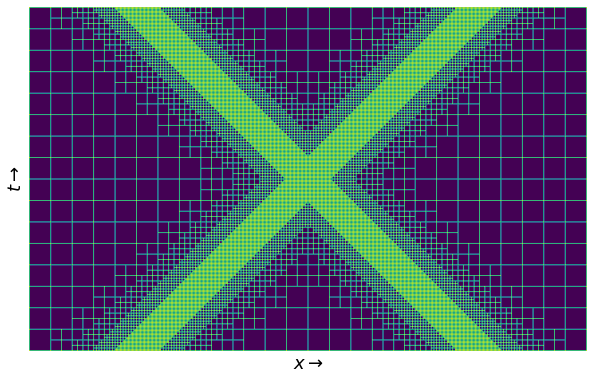

130 ms ± 44.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [20]:
%%timeit -n 1 -r 10

# Benchmark for Kayran-Scheme using lattice_array

# comparison parameters for notebook settings:
# Number of Coarse Borders 4
# Spatial Width of Border Regions [Finest Resolution Units] 16
# Pulse Segment Repetitions 16
# Buffer Region Spatial Width [Coarsest Resolution Units] 1
# Pulse Kernel Spatial Width [Finest Resolution Units] 34

clear_output()

plot_lattice = generate_plot_lattice_1_1D(
        pulse_collision(
            4,
            16,
            34,
            16,
            1,
        )
    )

plot_mesh_1_1D(plot_lattice)
plt.show()

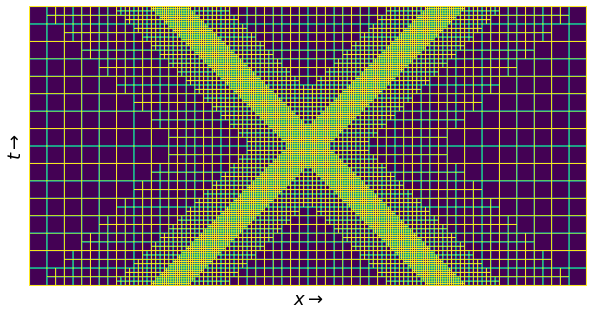

85.4 ms ± 8.52 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [21]:
%%timeit -n 1 -r 10

# Benchmark for Ipp-Scheme using lattice_array

# comparison parameters for notebook settings:
# Number of Coarse Borders 3
# Number of Cells per Border Region 8
# Pulse Segment Repetitions 16
# Buffer Region Spatial Width [Coarsest Resolution Units] 1
# Pulse Kernel Spatial Width [Finest Resolution Units] 18


clear_output()

plot_lattice = generate_plot_lattice_1_1D(
        fixed_borders_pulse_collision(
            3,
            8,
            18,
            16,
            1,
        )
    )

plot_mesh_1_1D(plot_lattice)
plt.show()

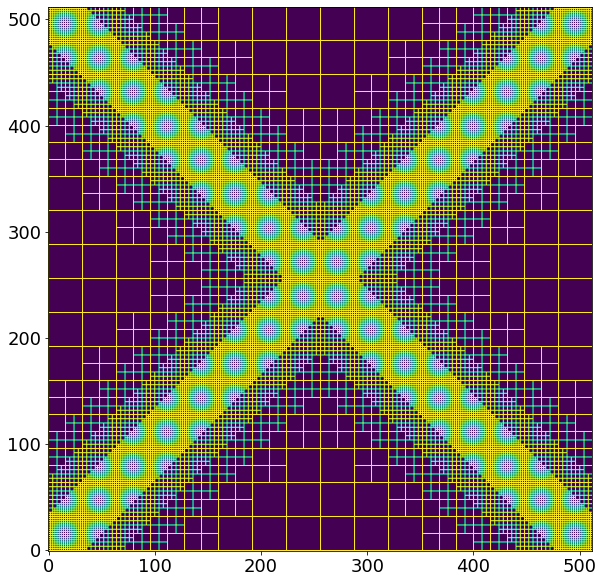

314 ms ± 6.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [22]:
%%timeit -n 1 -r 10

# code from A.IPP "adaptive_mesh_construction_v03"
# kayran-scheme

# comparison parameters for notebook settings:
# Number of Coarse Borders 4
# Spatial Width of Border Regions [Finest Resolution Units] 16
# Pulse Segment Repetitions 16
# Buffer Region Spatial Width [Coarsest Resolution Units] 1
# Pulse Kernel Spatial Width [Finest Resolution Units] 34

clear_output()

# parameters:
steps = 4
scale = 1

# line_1 = kayran_line(4, 2)
max_size = 2 ** steps
line_1 = [x for x in np.exp2(range(steps)).astype(int) for z in range(max_size * scale)]

# mesh_1 = create_propagating_pulse_mesh(line_1, 512, 512, 2 * max(line_1))
fill = 2 * max(line_1)
size_x = 256
size_t = 256
line = [fill] * size_x + line_1[::-1] + line_1 + [fill] * size_x

start = (len(line) - size_t - size_x) // 2
mesh = [line[start + t : start + t + size_x] for t in range(size_t)]
mesh_1 = np.asarray(mesh)

# produce reverse pulse
mesh_reverse = mesh_1[::, ::-1]
mesh_1 = np.minimum(mesh_1, mesh_reverse)

# fixed_mesh_1 = fix_coarse_graining(np.asarray(mesh_1))
max_log2 = math.floor(math.log2(min(mesh_1.shape[0], mesh_1.shape[1])))
m = (mesh_1 >= 1) * 1

scale = 1
for i in range(max_log2):
    # c = coarsegrain_mesh(mesh, scale)
    #       inflate_mesh(reduce_mesh(mesh, resolution), resolution)
    resolution = scale

    # m = reshape_mesh(mesh, resolution)
    d = np.reshape(
        mesh_1,
        (
            mesh_1.shape[0] // resolution,
            resolution,
            mesh_1.shape[1] // resolution,
            resolution,
        ),
    )
    d = np.transpose(d, axes=(0, 2, 1, 3))

    d = np.min(d, axis=3)
    d = np.min(d, axis=2)

    c = np.reshape(d, (d.shape[0], d.shape[1], 1))
    c = np.repeat(c, resolution * resolution, axis=2)
    c = np.reshape(c, (d.shape[0], d.shape[0], resolution, resolution))
    c = np.transpose(c, (0, 2, 1, 3))
    c = np.reshape(c, (d.shape[0] * resolution, d.shape[1] * resolution))

    c = (c >= scale) * scale
    m = np.maximum(m, c)
    scale = scale * 2

fixed_mesh_1 = m

# inflate_mesh(fixed_mesh_1, 2) * 2
resolution = 2
m = np.reshape(fixed_mesh_1, (fixed_mesh_1.shape[0], fixed_mesh_1.shape[1], 1))
m = np.repeat(m, resolution * resolution, axis=2)
m = np.reshape(m, (fixed_mesh_1.shape[0], fixed_mesh_1.shape[0], resolution, resolution))
m = np.transpose(m, (0, 2, 1, 3))
m = np.reshape(m, (fixed_mesh_1.shape[0] * resolution, fixed_mesh_1.shape[1] * resolution))

fixed_mesh_1 = m *2

# plot_encoding(fixed_mesh_1)
max_log2 = math.floor(math.log2(min(fixed_mesh_1.shape[0], fixed_mesh_1.shape[1])))
scale = 1
m = (fixed_mesh_1 == 0) * 0
for i in range(max_log2):
    rectangles = np.asarray(
        [
            [(x % scale == 0) or (y % scale == 0) for x in range(fixed_mesh_1.shape[0])]
            for y in range(fixed_mesh_1.shape[1])
        ]
    )
    positions = fixed_mesh_1 == scale
    positions = np.logical_and(positions, rectangles)
    m = np.maximum(m, positions)
    scale = scale * 2

plot_mesh_1 = m
plt.imshow(plot_mesh_1, origin="lower")
plt.show()

In [23]:
%%timeit -n 1 -r 10

# code from A.IPP "adaptive_mesh_construction_v03"
# ipp-scheme

# comparison parameters for notebook settings:
# Number of Coarse Borders 3
# Number of Cells per Border Region 8
# Pulse Segment Repetitions 16
# Buffer Region Spatial Width [Coarsest Resolution Units] 1
# Pulse Kernel Spatial Width [Finest Resolution Units] 18

clear_output()

# line_2 = const_line(4, 4)

steps = 4
width = 8

max_size = 2 ** steps
line_2 = [x for x in np.exp2(range(steps)).astype(int) for y in range(width * x)]

# mesh_2 = create_propagating_pulse_mesh(line_2, 512, 512, 2 * max(line_2))
fill = 2 * max(line_2)
size_x = 256
size_t = 256
line = [fill] * size_x + line_2[::-1] + line_2 + [fill] * size_x

start = (len(line) - size_t - size_x) // 2
mesh = [line[start + t : start + t + size_x] for t in range(size_t)]
mesh_2 = np.asarray(mesh)

# produce reverse pulse
mesh_reverse = mesh_2[::, ::-1]
mesh_2 = np.minimum(mesh_2, mesh_reverse)

# fixed_mesh_2 = fix_coarse_graining(np.asarray(mesh_2))
max_log2 = math.floor(math.log2(min(mesh_2.shape[0], mesh_2.shape[1])))
m = (mesh_2 >= 1) * 1

scale = 1
for i in range(max_log2):
    # c = coarsegrain_mesh(mesh, scale)
    #       inflate_mesh(reduce_mesh(mesh, resolution), resolution)
    resolution = scale

    # m = reshape_mesh(mesh, resolution)
    d = np.reshape(
        mesh_2,
        (
            mesh_2.shape[0] // resolution,
            resolution,
            mesh_2.shape[1] // resolution,
            resolution,
        ),
    )
    d = np.transpose(d, axes=(0, 2, 1, 3))

    d = np.min(d, axis=3)
    d = np.min(d, axis=2)

    c = np.reshape(d, (d.shape[0], d.shape[1], 1))
    c = np.repeat(c, resolution * resolution, axis=2)
    c = np.reshape(c, (d.shape[0], d.shape[0], resolution, resolution))
    c = np.transpose(c, (0, 2, 1, 3))
    c = np.reshape(c, (d.shape[0] * resolution, d.shape[1] * resolution))

    c = (c >= scale) * scale
    m = np.maximum(m, c)
    scale = scale * 2

fixed_mesh_2 = m

# inflate_mesh(fixed_mesh_2, 2) * 2
resolution = 2
m = np.reshape(fixed_mesh_2, (fixed_mesh_2.shape[0], fixed_mesh_2.shape[1], 1))
m = np.repeat(m, resolution * resolution, axis=2)
m = np.reshape(m, (fixed_mesh_2.shape[0], fixed_mesh_2.shape[0], resolution, resolution))
m = np.transpose(m, (0, 2, 1, 3))
m = np.reshape(m, (fixed_mesh_2.shape[0] * resolution, fixed_mesh_2.shape[1] * resolution))

fixed_mesh_2 = m *2

# plot_encoding(fixed_mesh_2)
max_log2 = math.floor(math.log2(min(fixed_mesh_2.shape[0], fixed_mesh_2.shape[1])))
scale = 1
m = (fixed_mesh_2 == 0) * 0
for i in range(max_log2):
    rectangles = np.asarray(
        [
            [(x % scale == 0) or (y % scale == 0) for x in range(fixed_mesh_2.shape[0])]
            for y in range(fixed_mesh_2.shape[1])
        ]
    )
    positions = fixed_mesh_2 == scale
    positions = np.logical_and(positions, rectangles)
    m = np.maximum(m, positions)
    scale = scale * 2

plot_mesh_2 = m
plt.imshow(plot_mesh_2, origin="lower")
plt.show()

311 ms ± 4.71 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [24]:
%%html
<style type='text/css'>
.rendered_html td, th{
font-size: 17px;
</style>

## Benchmark Results

on Intel 6700K @ 4.7GHz

|   | Kayran-Scheme | Ipp-Scheme |
|:-:|:-------------:|:----------:|
| lattice_array | 115 ms ± 37.9 | 72.9 ms ± 1.12 |
| pure Numpy | 313 ms ± 6.63 | 314 ms ± 4.11 |